In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns; sns.set();
import matplotlib.pyplot as plt

# Hourly Approach

## Import Data

In [2]:
# Electricity generation data
elec_gen_df = pd.read_csv('../data/electricity/elec_gen_hourly_jul_dec_2018.csv', low_memory = False)

# Electricity price data
elec_prc_df = pd.read_csv('../data/electricity/elc_price_hourly_2018_ercot.csv')

## Clean Data

In [3]:
## Fix column names

elec_prc_df.columns = [x.replace(' ', '_').lower() for x in elec_prc_df.columns]

elec_gen_df.columns = [x.replace(' ', '_').replace('(', '').replace(')', '').lower() for x in elec_gen_df.columns]
elec_gen_df.rename(columns = {'hour_number': 'delivery_hour', 'data_date': 'delivery_date'}, inplace = True)

In [4]:
## Subset data

elec_prc_subset_df = elec_prc_df.copy().query(
    'settlement_point_name == "HB_BUSAVG" & delivery_interval == 1 & repeated_hour_flag == "N"')

elec_gen_subset_df = elec_gen_df.copy().query('balancing_authority == "ERCO"')

In [5]:
## Fix numbers: convert to floats

elec_prc_subset_df['settlement_point_price'] = elec_prc_subset_df['settlement_point_price'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)

elec_gen_subset_df['net_generation_mw'] = elec_gen_subset_df['net_generation_mw'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)

elec_gen_subset_df['demand_mw'] = elec_gen_subset_df['demand_mw'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)

## Merge Data

In [6]:
## Merge
elec_gen_prc_df = elec_gen_subset_df.merge(elec_prc_subset_df, on = ['delivery_date', 'delivery_hour'])

## Subset to normal prices and quantities
elec_gen_prc_df = elec_gen_prc_df.query('settlement_point_price > 0 & net_generation_mw > 0')

In [7]:
elec_gen_prc_df.head()

,balancing_authority,delivery_date,delivery_hour,local_time_at_end_of_hour,utc_time_at_end_of_hour,demand_forecast_mw,demand_mw,net_generation_mw,total_interchange_mw,sumvalid_dibas_mw,...,net_generation_mw_from_hydropower_and_pumped_storage,net_generation_mw_from_solar,net_generation_mw_from_wind,net_generation_mw_from_other_fuel_sources,net_generation_mw_from_unknown_fuel_sources,delivery_interval,repeated_hour_flag,settlement_point_name,settlement_point_type,settlement_point_price
1728,ERCO,09/11/2018,1,09/11/2018 1:00:00 AM,09/11/2018 6:00:00 AM,NaN,36104.0,36082.0,-23,-24,...,3,0,"4,800",13,NaN,1,N,HB_BUSAVG,SH,18.62
1729,ERCO,09/11/2018,2,09/11/2018 2:00:00 AM,09/11/2018 7:00:00 AM,NaN,34597.0,34405.0,-192,-193,...,4,0,"4,501",15,NaN,1,N,HB_BUSAVG,SH,17.81
1730,ERCO,09/11/2018,3,09/11/2018 3:00:00 AM,09/11/2018 8:00:00 AM,NaN,33692.0,33363.0,-330,-330,...,5,0,"4,128",11,NaN,1,N,HB_BUSAVG,SH,17.78
1731,ERCO,09/11/2018,4,09/11/2018 4:00:00 AM,09/11/2018 9:00:00 AM,NaN,33341.0,33150.0,-191,-191,...,5,0,"3,895",12,NaN,1,N,HB_BUSAVG,SH,17.62
1732,ERCO,09/11/2018,5,09/11/2018 5:00:00 AM,09/11/2018 10:00:00 AM,NaN,33674.0,33315.0,-359,-359,...,5,0,"4,018",12,NaN,1,N,HB_BUSAVG,SH,17.69


In [8]:
## Pivot dataframe
egp_pivot_df = elec_gen_prc_df.pivot(index = 'delivery_date', 
                                     values = ['net_generation_mw', 'settlement_point_price'], 
                                     columns = 'delivery_hour')

# Flatten hierarchical column names
egp_pivot_df.columns = ['net_gen_' + str(i) for i in range(1,25)] + ['price_' + str(i) for i in range(1,25)]

# Reset index
egp_pivot_df = egp_pivot_df.reset_index()

In [9]:
egp_pivot_df.head()

,delivery_date,net_gen_1,net_gen_2,net_gen_3,net_gen_4,net_gen_5,net_gen_6,net_gen_7,net_gen_8,net_gen_9,...,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24
0,09/11/2018,36082.0,34405.0,33363.0,33150.0,33315.0,35146.0,38747.0,40140.0,40460.0,...,25.20,26.17,26.45,27.74,25.52,24.93,27.70,23.59,20.52,19.04
1,09/12/2018,36894.0,35364.0,34269.0,33823.0,34152.0,36049.0,39598.0,40949.0,41510.0,...,50.50,52.37,73.01,55.44,27.91,39.68,42.47,30.14,23.08,19.65
2,09/13/2018,39176.0,37340.0,36150.0,35512.0,35637.0,37392.0,40771.0,41726.0,42303.0,...,31.01,30.53,32.19,31.48,28.78,28.37,33.78,24.34,20.82,19.81
3,09/14/2018,40008.0,37981.0,36603.0,35708.0,35600.0,37144.0,40379.0,41662.0,42259.0,...,28.69,29.17,28.34,28.81,26.10,27.20,26.47,22.98,20.51,19.53
4,09/15/2018,38600.0,36813.0,35642.0,34891.0,34645.0,35083.0,36061.0,36858.0,39046.0,...,38.74,50.22,31.27,37.58,26.76,27.14,26.03,26.49,21.10,20.78


## Plots

In [22]:
elec_gen_prc_df.head()

,balancing_authority,delivery_date,delivery_hour,local_time_at_end_of_hour,utc_time_at_end_of_hour,demand_forecast_mw,demand_mw,net_generation_mw,total_interchange_mw,sumvalid_dibas_mw,...,net_generation_mw_from_solar,net_generation_mw_from_wind,net_generation_mw_from_other_fuel_sources,net_generation_mw_from_unknown_fuel_sources,delivery_interval,repeated_hour_flag,settlement_point_name,settlement_point_type,settlement_point_price,month
1728,ERCO,09/11/2018,1,09/11/2018 1:00:00 AM,09/11/2018 6:00:00 AM,NaN,36104.0,36082.0,-23,-24,...,0,"4,800",13,NaN,1,N,HB_BUSAVG,SH,18.62,11
1729,ERCO,09/11/2018,2,09/11/2018 2:00:00 AM,09/11/2018 7:00:00 AM,NaN,34597.0,34405.0,-192,-193,...,0,"4,501",15,NaN,1,N,HB_BUSAVG,SH,17.81,11
1730,ERCO,09/11/2018,3,09/11/2018 3:00:00 AM,09/11/2018 8:00:00 AM,NaN,33692.0,33363.0,-330,-330,...,0,"4,128",11,NaN,1,N,HB_BUSAVG,SH,17.78,11
1731,ERCO,09/11/2018,4,09/11/2018 4:00:00 AM,09/11/2018 9:00:00 AM,NaN,33341.0,33150.0,-191,-191,...,0,"3,895",12,NaN,1,N,HB_BUSAVG,SH,17.62,11
1732,ERCO,09/11/2018,5,09/11/2018 5:00:00 AM,09/11/2018 10:00:00 AM,NaN,33674.0,33315.0,-359,-359,...,0,"4,018",12,NaN,1,N,HB_BUSAVG,SH,17.69,11


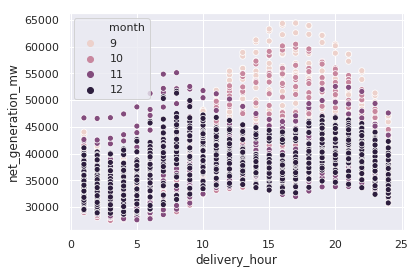

In [27]:
elec_gen_prc_df['month'] = elec_gen_prc_df['delivery_date'].apply(lambda x: int(x[0:2]))
sns.scatterplot(data = elec_gen_prc_df, y = 'net_generation_mw', x = 'delivery_hour', hue = 'month')

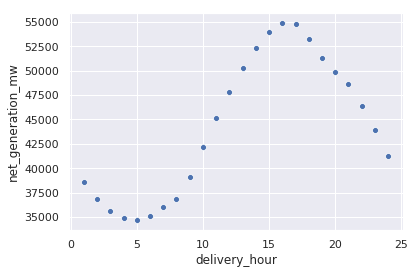

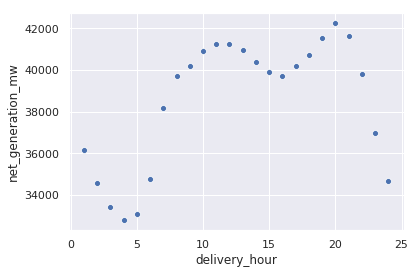

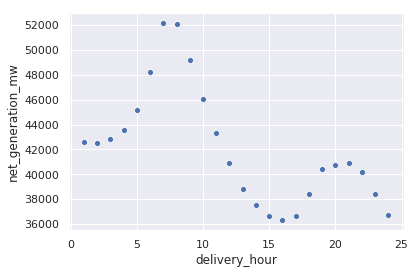

In [31]:
plt.figure()
sns.scatterplot(data = elec_gen_prc_df.query('delivery_date == "09/15/2018"'), y = 'net_generation_mw', x = 'delivery_hour')
plt.figure()
sns.scatterplot(data = elec_gen_prc_df.query('delivery_date == "10/15/2018"'), y = 'net_generation_mw', x = 'delivery_hour')
plt.figure()
sns.scatterplot(data = elec_gen_prc_df.query('delivery_date == "11/15/2018"'), y = 'net_generation_mw', x = 'delivery_hour')

## Regressions

In [10]:
for i in range(1,25):
    
    for j in range(1,25): 
        
        egp_pivot_df['log_net_gen_{0}_{1}'.format(i,j)] = np.log(
            np.divide(egp_pivot_df['net_gen_' + str(i)], egp_pivot_df['net_gen_' + str(j)]))
        
        egp_pivot_df['log_price_{0}_{1}'.format(i,j)]   = np.log(
            np.divide(egp_pivot_df['price_' + str(i)], egp_pivot_df['price_' + str(j)]))

egp_pivot_df['month_idx']   = egp_pivot_df['delivery_date'].apply(lambda x: 'month_' + x[:2])

In [24]:
egp_pivot_df.head()

,delivery_date,net_gen_1,net_gen_2,net_gen_3,net_gen_4,net_gen_5,net_gen_6,net_gen_7,net_gen_8,net_gen_9,...,log_price_24_20,log_net_gen_24_21,log_price_24_21,log_net_gen_24_22,log_price_24_22,log_net_gen_24_23,log_price_24_23,log_net_gen_24_24,log_price_24_24,month_idx
0,09/11/2018,36082.0,34405.0,33363.0,33150.0,33315.0,35146.0,38747.0,40140.0,40460.0,...,-0.269530,-0.167565,-0.374890,-0.140364,-0.214281,-0.070034,-0.074858,0.0,0.0,month_09
1,09/12/2018,36894.0,35364.0,34269.0,33823.0,34152.0,36049.0,39598.0,40949.0,41510.0,...,-0.702770,-0.201820,-0.770721,-0.156617,-0.427776,-0.082534,-0.160889,0.0,0.0,month_09
2,09/13/2018,39176.0,37340.0,36150.0,35512.0,35637.0,37392.0,40771.0,41726.0,42303.0,...,-0.359145,-0.193896,-0.533682,-0.153099,-0.205934,-0.081933,-0.049727,0.0,0.0,month_09
3,09/14/2018,40008.0,37981.0,36603.0,35708.0,35600.0,37144.0,40379.0,41662.0,42259.0,...,-0.331265,-0.153720,-0.304060,-0.120985,-0.162673,-0.065502,-0.048961,0.0,0.0,month_09
4,09/15/2018,38600.0,36813.0,35642.0,34891.0,34645.0,35083.0,36061.0,36858.0,39046.0,...,-0.267018,-0.163486,-0.225259,-0.115401,-0.242776,-0.060904,-0.015282,0.0,0.0,month_09


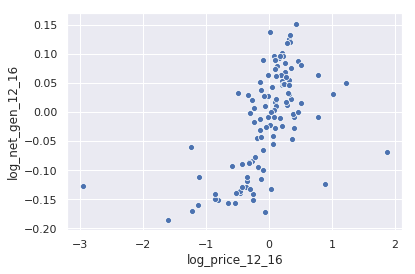

In [25]:
sns.scatterplot(x = 'log_price_12_16', y = 'log_net_gen_12_16', data = egp_pivot_df)

In [26]:
smf.ols('log_net_gen_12_14 ~ log_price_14_12 + month_idx', data = egp_pivot_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_net_gen_12_14   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     49.96
Date:                Thu, 28 Feb 2019   Prob (F-statistic):           1.77e-23
Time:                        12:40:05   Log-Likelihood:                 219.66
No. Observations:                 110   AIC:                            -429.3
Df Residuals:                     105   BIC:                            -415.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0674      0.008     -8.460      0.000      -0.083      -0.052
month_idx[T.month_10]     0.0283      0.010      2.846      0.005       0.009       0.048
month_idx[T.month_11]     0.0879      0.010      8.577      0.000       0.068       0.108
month_idx[T.month_12]     0.1015      0.010      9.862      0.000       0.081       0.122
log_price_14_12          -0.0306      0.009     -3.415      0.001      -0.048      -0.013
==============================================================================
Omnibus:                       12.516   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                4.113
Skew:                           0.032   Prob(JB):                        0.128
Kurtosis:                       2.055   Cond. No.                         6.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### All possible (table)

In [27]:
elas_est = np.zeros((12,12))

for i in range(1,13):
    for j in range(1,13):
        
        elas_est[i-1, j-1] = smf.ols('log_net_gen_{0}_{1} ~ log_price_{1}_{0}'.format(i, j), 
                                     data = egp_pivot_df).fit().params[1]

elas_df = pd.DataFrame(elas_est)
elas_df.columns = list(range(1,13))
elas_df.index   = list(range(1,13))
elas_df

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.000000,-0.011369,-0.016225,-0.012098,-0.017516,-0.025291,-0.033189,-0.034110,-0.022910,-0.017812,-0.013209,-0.017631
2,-0.011369,0.000000,-0.003585,-0.005578,-0.004749,-0.014727,-0.027291,-0.028474,-0.015034,-0.011924,-0.007970,-0.017543
3,-0.016225,-0.003585,0.000000,-0.002900,0.003522,-0.007292,-0.030332,-0.071560,-0.049924,-0.029245,-0.015190,-0.042996
4,-0.012098,-0.005578,-0.002900,0.000000,0.001867,0.000826,-0.014099,-0.028621,-0.019155,-0.015439,-0.014594,-0.031519
5,-0.017516,-0.004749,0.003522,0.001867,0.000000,-0.002507,-0.012473,-0.030674,-0.019722,-0.013334,-0.015918,-0.039476
6,-0.025291,-0.014727,-0.007292,0.000826,-0.002507,0.000000,-0.009062,-0.041592,-0.022892,-0.008193,-0.025699,-0.082564
7,-0.033189,-0.027291,-0.030332,-0.014099,-0.012473,-0.009062,0.000000,-0.001107,-0.017064,-0.030691,-0.045745,-0.080170
8,-0.034110,-0.028474,-0.071560,-0.028621,-0.030674,-0.041592,-0.001107,0.000000,-0.034824,-0.047486,-0.077481,-0.116038
9,-0.022910,-0.015034,-0.049924,-0.019155,-0.019722,-0.022892,-0.017064,-0.034824,0.000000,-0.007291,-0.043652,-0.095959
10,-0.017812,-0.011924,-0.029245,-0.015439,-0.013334,-0.008193,-0.030691,-0.047486,-0.007291,0.000000,-0.021711,-0.062417


### Divided by Hour 1 Data

In [109]:
egp_h1_df = elec_gen_prc_df.copy()

In [110]:
# Add hour 1 data for each date
h1_dict = egp_h1_df.query('delivery_hour == 1')[['delivery_date', 'net_generation_mw', 'settlement_point_price']].set_index('delivery_date').to_dict()
egp_h1_df['h1_demand'] = egp_h1_df['delivery_date'].apply(lambda x: h1_dict['net_generation_mw'].get(x))
egp_h1_df['h1_price']  = egp_h1_df['delivery_date'].apply(lambda x: h1_dict['settlement_point_price'].get(x))

In [111]:
# Divide data by respective hour 1 data
egp_h1_df['elc_demand_by_h1'] = np.divide(egp_h1_df['net_generation_mw'],      egp_h1_df['h1_demand'])
egp_h1_df['elc_price_by_h1']  = np.divide(egp_h1_df['settlement_point_price'], egp_h1_df['h1_price'])

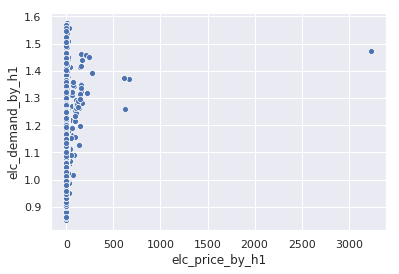

In [112]:
sns.scatterplot(x = 'elc_price_by_h1', y = 'elc_demand_by_h1', data = egp_h1_df)

In [113]:
egp_h1_df.to_csv('../data/processed/egp_h1_eos_est.csv', index = False)

# Monthly Approach

## Import Data

In [463]:
sales_df = pd.read_csv('../data/electricity/retail_sales.csv')
price_df = pd.read_csv('../data/electricity/avg_elec_price.csv')

## Clean Data

In [464]:
# Fix state names
sales_df['State Name'] = sales_df['State Name'].apply(lambda x: x.strip().lower()) 
price_df['State Name'] = price_df['State Name'].apply(lambda x: x.strip().lower()) 

# Melt dataframes
sales_melt_df = pd.melt(sales_df.query('Sector == "All"'), id_vars = ['State Name'],
        value_vars = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                      'August', 'September', 'October', 'November', 'December'],
        var_name   = 'Month',
        value_name = 'elc_demand')

price_melt_df = pd.melt(price_df.query('Sector == " all sectors"'), id_vars = ['State Name'],
        value_vars = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                      'August', 'September', 'October', 'November', 'December'],
        var_name   = 'Month',
        value_name = 'elc_price')

## Merge Data

In [471]:
elc_sales_price_df = sales_melt_df.merge(price_melt_df, on = ['State Name', 'Month'])
elc_sales_price_df.columns = [x.replace(' ', '_').lower() for x in elc_sales_price_df.columns]

elc_sales_price_df.head()

,state_name,month,elc_demand,elc_price
0,connecticut,January,2553,17.18
1,maine,January,1000,12.90
2,massachusetts,January,4662,16.62
3,new hampshire,January,941,15.77
4,rhode island,January,654,16.76


In [474]:
## Pivot dataframe
esp_pivot_df = elc_sales_price_df.pivot(index = 'state_name', 
                                     values = ['elc_demand', 'elc_price'], 
                                     columns = 'month')

# Flatten hierarchical column names
esp_pivot_df.columns = ['elc_demand_' + str(i) for i in range(1,13)] + ['elc_price_' + str(i) for i in range(1,13)]

# Reset index
esp_pivot_df = esp_pivot_df.reset_index()

## Plots

In [506]:
esp_pivot_df.head()

,state_name,elc_demand_1,elc_demand_2,elc_demand_3,elc_demand_4,elc_demand_5,elc_demand_6,elc_demand_7,elc_demand_8,elc_demand_9,...,log_elc_demand_12_8,log_elc_price_12_8,log_elc_demand_12_9,log_elc_price_12_9,log_elc_demand_12_10,log_elc_price_12_10,log_elc_demand_12_11,log_elc_price_12_11,log_elc_demand_12_12,log_elc_price_12_12
0,alabama,6194.0,8866.0,7042.0,6968.0,7688.0,8824.0,8014.0,6437.0,6904.0,...,0.230172,0.090303,0.160133,0.066414,0.249307,0.058932,0.164925,0.015175,0.0,0.0
1,alaska,480.0,494.0,595.0,535.0,577.0,473.0,462.0,527.0,469.0,...,-0.114468,0.023211,0.002130,-0.016098,-0.127663,-0.028140,-0.073804,-0.021590,0.0,0.0
2,arizona,5400.0,8523.0,5537.0,5199.0,5918.0,9120.0,8223.0,5327.0,6260.0,...,0.285756,0.162945,0.124364,0.027550,0.295945,0.153396,0.107102,0.064539,0.0,0.0
3,arkansas,3220.0,4741.0,3609.0,3745.0,3899.0,4826.0,3863.0,3423.0,3291.0,...,0.239429,0.106262,0.278754,0.089648,0.245289,0.093458,0.129957,0.065853,0.0,0.0
4,california,19148.0,27016.0,20757.0,18597.0,20117.0,23900.0,22358.0,20225.0,19390.0,...,0.179020,0.151944,0.221182,0.110730,0.203242,0.107371,0.122175,0.161810,0.0,0.0


## Regressions

In [478]:
for i in range(1,13):
    for j in range(1,13): 
        
        esp_pivot_df['log_elc_demand_{0}_{1}'.format(i,j)] = np.log(
            np.divide(esp_pivot_df['elc_demand_' + str(i)], esp_pivot_df['elc_demand_' + str(j)]))
        
        esp_pivot_df['log_elc_price_{0}_{1}'.format(i,j)]   = np.log(
            np.divide(esp_pivot_df['elc_price_' + str(i)], esp_pivot_df['elc_price_' + str(j)]))


In [479]:
esp_pivot_df.head()

,state_name,elc_demand_1,elc_demand_2,elc_demand_3,elc_demand_4,elc_demand_5,elc_demand_6,elc_demand_7,elc_demand_8,elc_demand_9,...,log_elc_demand_12_8,log_elc_price_12_8,log_elc_demand_12_9,log_elc_price_12_9,log_elc_demand_12_10,log_elc_price_12_10,log_elc_demand_12_11,log_elc_price_12_11,log_elc_demand_12_12,log_elc_price_12_12
0,alabama,6194.0,8866.0,7042.0,6968.0,7688.0,8824.0,8014.0,6437.0,6904.0,...,0.230172,0.090303,0.160133,0.066414,0.249307,0.058932,0.164925,0.015175,0.0,0.0
1,alaska,480.0,494.0,595.0,535.0,577.0,473.0,462.0,527.0,469.0,...,-0.114468,0.023211,0.002130,-0.016098,-0.127663,-0.028140,-0.073804,-0.021590,0.0,0.0
2,arizona,5400.0,8523.0,5537.0,5199.0,5918.0,9120.0,8223.0,5327.0,6260.0,...,0.285756,0.162945,0.124364,0.027550,0.295945,0.153396,0.107102,0.064539,0.0,0.0
3,arkansas,3220.0,4741.0,3609.0,3745.0,3899.0,4826.0,3863.0,3423.0,3291.0,...,0.239429,0.106262,0.278754,0.089648,0.245289,0.093458,0.129957,0.065853,0.0,0.0
4,california,19148.0,27016.0,20757.0,18597.0,20117.0,23900.0,22358.0,20225.0,19390.0,...,0.179020,0.151944,0.221182,0.110730,0.203242,0.107371,0.122175,0.161810,0.0,0.0


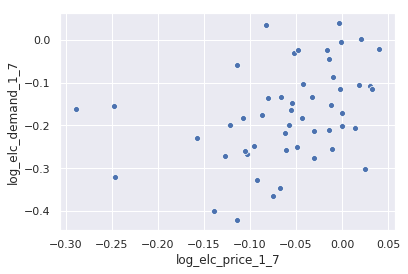

In [508]:
sns.scatterplot(y = 'log_elc_demand_1_7', x = 'log_elc_price_1_7', data = esp_pivot_df)

In [490]:
smf.ols('log_elc_demand_1_5 ~ log_elc_price_1_5', data = esp_pivot_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_elc_demand_1_5   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     8.161
Date:                Wed, 20 Feb 2019   Prob (F-statistic):            0.00626
Time:                        19:01:24   Log-Likelihood:                 68.456
No. Observations:                  51   AIC:                            -132.9
Df Residuals:                      49   BIC:                            -129.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1887      0.009    -20.809      0.000      -0.207      -0.170
log_elc_price_1_5    -0.6455      0.226     -2.857      0.006      -1.100      -0.191
==============================================================================
Omnibus:                        0.948   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.315
Skew:                          -0.071   Prob(JB):                        0.854
Kurtosis:                       3.358   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### All possible (table)

In [500]:
elas_est = np.zeros((12,12))

for i in range(1,13):
    for j in range(1,13):
        
        elas_est[i-1, j-1] = smf.ols('log_elc_demand_{0}_{1} ~ log_elc_price_{1}_{0}'.format(i, j), 
                                     data = esp_pivot_df).fit().params[1]

In [504]:
elas_df = pd.DataFrame(elas_est)
elas_df.columns = list(range(1,13))
elas_df.index   = list(range(1,13))
elas_df

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.000000,-0.279310,0.330965,0.580274,0.645468,-0.396541,-0.577270,0.286498,-0.184672,-0.110066,-0.671133,-0.367258
2,-0.279310,0.000000,-0.457269,-0.411627,-0.243380,-0.183112,0.070929,-0.475383,-0.182110,-0.545769,-0.215407,-0.389292
3,0.330965,-0.457269,0.000000,0.036602,-0.018723,-0.546083,-0.521500,0.145699,0.194360,0.426053,-0.296647,-0.606812
4,0.580274,-0.411627,0.036602,0.000000,0.381313,-0.537144,-0.620107,0.422252,-0.191441,-0.083760,-0.566566,-0.598132
5,0.645468,-0.243380,-0.018723,0.381313,0.000000,-0.394736,-0.401097,0.655242,0.252185,-0.021352,-0.172493,-0.346864
6,-0.396541,-0.183112,-0.546083,-0.537144,-0.394736,0.000000,0.344215,-0.653689,-0.380697,-0.713970,-0.335453,-0.510454
7,-0.577270,0.070929,-0.521500,-0.620107,-0.401097,0.344215,0.000000,-0.801356,-0.532839,-0.801536,-0.463747,-0.709145
8,0.286498,-0.475383,0.145699,0.422252,0.655242,-0.653689,-0.801356,0.000000,-0.388940,-0.021050,-0.714583,-0.640440
9,-0.184672,-0.182110,0.194360,-0.191441,0.252185,-0.380697,-0.532839,-0.388940,0.000000,-0.336541,-0.124559,-0.314875
10,-0.110066,-0.545769,0.426053,-0.083760,-0.021352,-0.713970,-0.801536,-0.021050,-0.336541,0.000000,-0.511980,-0.566437


### Divided by Jan Data

In [534]:
esp_jan_df = elc_sales_price_df.copy()

In [535]:
# Add January data for each state
jan_dict = esp_jan_df.query('month == "January"')[['state_name', 'elc_demand', 'elc_price']].set_index('state_name').to_dict()
esp_jan_df['jan_demand'] = esp_jan_df['state_name'].apply(lambda x: jan_dict['elc_demand'].get(x))
esp_jan_df['jan_price']  = esp_jan_df['state_name'].apply(lambda x: jan_dict['elc_price'].get(x))

In [536]:
# Divide data by respective January data
esp_jan_df['elc_demand_by_jan'] = np.divide(esp_jan_df['elc_demand'], esp_jan_df['jan_demand'])
esp_jan_df['elc_price_by_jan']  = np.divide(esp_jan_df['elc_price'], esp_jan_df['jan_price'])

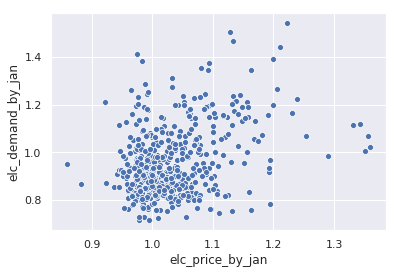

In [537]:
sns.scatterplot(x = 'elc_price_by_jan', y = 'elc_demand_by_jan', data = esp_jan_df)

In [543]:
esp_jan_df.head()

,state_name,month,elc_demand,elc_price,jan_demand,jan_price,elc_demand_by_jan,elc_price_by_jan
0,connecticut,January,2553,17.18,2553,17.18,1.0,1.0
1,maine,January,1000,12.90,1000,12.90,1.0,1.0
2,massachusetts,January,4662,16.62,4662,16.62,1.0,1.0
3,new hampshire,January,941,15.77,941,15.77,1.0,1.0
4,rhode island,January,654,16.76,654,16.76,1.0,1.0


In [555]:
from datetime import datetime as dt
esp_jan_df['month_num'] = esp_jan_df['month'].apply(lambda x: dt.strptime(x,'%B').month)

In [570]:
smf.ols('np.log(elc_demand_by_jan) ~ np.log(np.power(elc_price_by_jan, -1)*np.sin((month_num-1)/11*2*np.pi)+2)', data = esp_jan_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log(elc_demand_by_jan)   R-squared:                       0.088
Model:                                   OLS   Adj. R-squared:                  0.086
Method:                        Least Squares   F-statistic:                     58.77
Date:                       Thu, 21 Feb 2019   Prob (F-statistic):           7.02e-14
Time:                               13:18:39   Log-Likelihood:                 397.93
No. Observations:                        612   AIC:                            -791.9
Df Residuals:                            610   BIC:                            -783.0
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 0.0188      0.011      1.776      0.076      -0.002       0.040
np.log(np.power(elc_price_by_jan, -1) * np.sin((month_num - 1) / 11 * 2 * np.pi) + 2)    -0.1109      0.014     -7.666      0.000      -0.139      -0.083
==============================================================================
Omnibus:                       22.100   Durbin-Watson:                   0.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.660
Skew:                           0.417   Prob(JB):                     4.42e-06
Kurtosis:                       3.520   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [581]:
esp_jan_df.to_csv('../data/processed/esp_jan_eos_est.csv', index = False)

# Ercot Hourly Loads

In [168]:
# Electricity load data
elec_load_df = pd.read_excel('../data/electricity/elc_load_hourly_2018_ercot.xlsx')

# Electricity price data
elec_prc_df  = pd.read_csv('../data/electricity/elc_price_hourly_2018_ercot.csv')

# Weather data
weather_df = pd.read_csv('../data/temperature/TX_AUSTIN_hourly_rainfall_rad_temp_2018.csv')

# Wind data
wind_df = pd.read_csv('../data/wind/wind_austin_tx_2018.csv')

In [169]:
elec_prc_df.head()

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point Name,Settlement Point Type,Settlement Point Price
0,01/01/2018,1,1,N,HB_BUSAVG,SH,27.37
1,01/01/2018,1,2,N,HB_BUSAVG,SH,27.37
2,01/01/2018,1,3,N,HB_BUSAVG,SH,27.15
3,01/01/2018,1,4,N,HB_BUSAVG,SH,27.13
4,01/01/2018,1,1,N,HB_HOUSTON,HU,27.68


In [170]:
# CLean up electricity load data

elec_load_df         = elec_load_df[['HourEnding', 'SCENT']]
elec_load_df.columns = ['datetime', 'load']

elec_load_df['date'] = elec_load_df['datetime'].apply(lambda x: x[:10])
elec_load_df['hour'] = elec_load_df['datetime'].apply(lambda x: int(x[11:13]))

elec_load_df.sample(n=10)

,datetime,load,date,hour
3206,05/14/2018 16:00,9314.216632,05/14/2018,16
3833,06/09/2018 19:00,9576.074731,06/09/2018,19
8325,12/13/2018 22:00,7057.264658,12/13/2018,22
2704,04/23/2018 18:00,7426.903252,04/23/2018,18
1663,03/11/2018 09:00,4685.884411,03/11/2018,9
1329,02/25/2018 10:00,5047.445518,02/25/2018,10
3058,05/08/2018 12:00,6873.977679,05/08/2018,12
5069,07/31/2018 07:00,7270.820358,07/31/2018,7
1872,03/20/2018 02:00,4232.048633,03/20/2018,2
3643,06/01/2018 21:00,10360.678525,06/01/2018,21


In [171]:
# Clean up electricity price data

elec_prc_df.columns = [x.replace(' ', '_').lower() for x in elec_prc_df.columns]

elec_prc_df = elec_prc_df.copy().query(
    'settlement_point_name == "HB_BUSAVG" & delivery_interval == 1 & repeated_hour_flag == "N"')

elec_prc_df['settlement_point_price'] = elec_prc_df['settlement_point_price'].apply(
    lambda x: float(x.replace(',', '')) if x == x else np.nan)


elec_prc_df         = elec_prc_df[['delivery_date', 'delivery_hour', 'settlement_point_price']]
elec_prc_df.columns = ['date', 'hour', 'price']

elec_prc_df.sample(n=10)

,date,hour,price
354200,06/17/2018,19,35.67
426624,07/22/2018,2,16.50
328592,06/05/2018,16,448.59
448184,08/01/2018,7,18.94
63448,01/31/2018,2,12.51
579920,10/02/2018,16,37.21
554928,09/20/2018,20,23.54
336864,06/09/2018,14,30.15
213136,04/11/2018,24,13.83
724152,12/09/2018,22,42.49


In [172]:
# Clean up weather data

weather_df.columns = [x.lower() for x in weather_df.columns]

weather_df = weather_df[['lst_date', 'lst_time', 't_hr_avg', 'p_calc', 'solarad']]
weather_df.columns = ['date', 'hour', 'temperature', 'precipitation', 'solar_rad']

weather_df['hour']        = weather_df['hour']/100
weather_df['temperature'] = weather_df['temperature'].apply(lambda x: x if x > -999 else np.nan)
weather_df['precipitation'] = weather_df['precipitation'].apply(lambda x: x if x < 9999 else np.nan)
weather_df['date']        = weather_df['date'].apply(lambda x: '{1}/{2}/{0}'.format(str(x)[:4], str(x)[4:6], str(x)[6:])) 

weather_df.sample(n=5)

,date,hour,temperature,precipitation,solar_rad
4937,07/25/2018,12.0,33.3,0.0,631
6573,10/01/2018,16.0,29.0,0.0,529
5107,08/01/2018,14.0,34.1,0.0,928
8387,12/16/2018,6.0,8.6,0.0,0
6497,09/28/2018,12.0,24.8,0.0,468


In [173]:
# Format wind data

def format_date(month, day, year):
    
    if int(day) < 10:
        day = '0' + day
    if int(month) < 10:
        month = '0' + month
    
    return '{0}/{1}/{2}'.format(month, day, str(year))

wind_df['date'] =  wind_df['date'].apply(lambda x: format_date(*x.split('/')))

In [174]:
# Merge data
elec_merged_df = elec_prc_df.merge(
    elec_load_df, on = ['date', 'hour']).merge(
    weather_df,   on = ['date', 'hour']).merge(
    wind_df,      on = ['date']).copy()

# Drop duplicates
elec_merged_df = elec_merged_df.groupby(['date', 'hour']).first().reset_index()

In [175]:
elec_merged_df.describe()

,hour,price,load,temperature,precipitation,solar_rad,wind_speed,uwnd,vwnd
count,8389.000000,8389.000000,8389.000000,8384.000000,8328.000000,8389.000000,8389.000000,8389.000000,8389.000000
mean,11.995709,29.115852,6876.454633,19.208469,0.122022,190.368697,-0.452597,-0.080399,1.531703
std,6.631559,53.409391,1842.158132,9.096950,1.473804,273.722529,5.077855,2.036321,4.414750
min,1.000000,-4.910000,3956.497702,-11.000000,0.000000,0.000000,-12.311020,-5.000000,-10.924997
25%,6.000000,18.370000,5588.407952,12.600000,0.000000,0.000000,-4.918588,-1.449999,-1.549999
50%,12.000000,20.950000,6406.613497,20.600000,0.000000,14.000000,-1.592560,-0.225000,2.100002
75%,18.000000,28.650000,7769.819906,25.600000,0.000000,323.000000,3.907126,1.300000,5.125000
max,23.000000,1402.230000,14166.701623,42.100000,94.100000,1078.000000,10.477413,7.050001,10.725000


In [176]:
from datetime import datetime

elec_merged_df['date_fmt'] = elec_merged_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
elec_merged_df['month']    = elec_merged_df['date_fmt'].apply(lambda x: int(x.month))

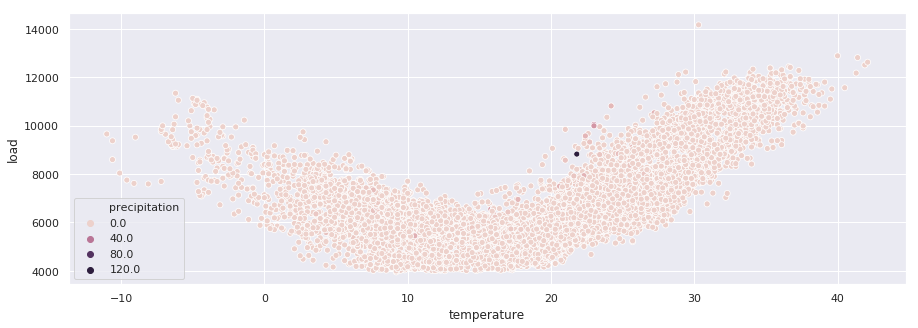

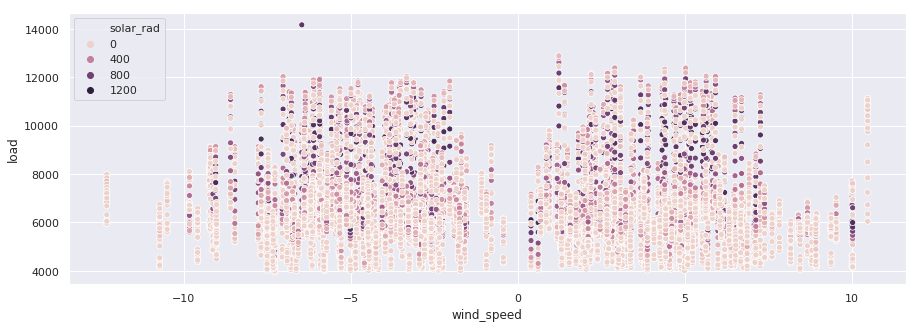

In [177]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = 'temperature', y = 'load', hue = 'precipitation', data = elec_merged_df)

plt.figure(figsize = (15,5))
sns.scatterplot(x = 'wind_speed', y = 'load', hue = 'solar_rad', data = elec_merged_df)

In [178]:
# Add relative values
elec_merged_df['price_rel'] = elec_merged_df['price']/elec_merged_df.query('date == "02/03/2018" & hour == 1')['price'].values
elec_merged_df['load_rel']  = elec_merged_df['load']/elec_merged_df.query('date == "02/03/2018" & hour == 1')['load'].values

In [179]:
# Add day indices
elec_merged_df['day'] = elec_merged_df['date_fmt'].apply(lambda x: x.timetuple().tm_yday)

In [180]:
elec_merged_df.sample(n=8)

,date,hour,price,datetime,load,temperature,precipitation,solar_rad,wind_speed,uwnd,vwnd,date_fmt,month,price_rel,load_rel,day
1947,03/26/2018,17,36.09,03/26/2018 17:00,7919.936283,27.3,0.0,350,-7.462112,-2.049999,7.175000,2018-03-26,3,1.906498,1.527898,85
6703,10/19/2018,12,51.31,10/19/2018 12:00,5803.722762,14.6,0.5,80,2.672193,-1.174999,-2.399999,2018-10-19,10,2.710512,1.119642,292
3511,06/02/2018,17,31.67,06/02/2018 17:00,11245.903266,36.0,0.0,494,5.801348,0.125001,5.800001,2018-06-02,6,1.673006,2.169536,153
5645,09/03/2018,12,22.74,09/03/2018 12:00,8250.024201,29.6,0.0,472,3.390611,-3.374998,-0.325000,2018-09-03,9,1.201268,1.591578,246
943,02/11/2018,1,18.87,02/11/2018 01:00,5772.016173,1.2,0.0,0,-9.210387,2.275001,-8.924999,2018-02-11,2,0.996830,1.113525,42
6717,10/20/2018,3,21.40,10/20/2018 03:00,4254.609155,15.2,0.0,0,-4.248602,1.500001,-3.974999,2018-10-20,10,1.130481,0.820790,293
4517,07/16/2018,11,24.27,07/16/2018 11:00,8489.707837,31.1,0.0,784,4.352657,0.675002,4.300000,2018-07-16,7,1.282092,1.637817,197
4238,07/04/2018,8,17.51,07/04/2018 08:00,6470.173228,26.1,0.0,273,-2.388121,-2.049999,1.225001,2018-07-04,7,0.924987,1.248212,185


In [181]:
# Export
elec_merged_df.sort_values(by = ['date_fmt', 'hour']).to_csv('../data/processed/ercot_load_price_2018.csv', index = False)

## Least squares fit

In [12]:
from scipy.optimize import least_squares, curve_fit

In [13]:
for i in range(1,13):
    elec_merged_df['m' + str(i) + '_dummy'] = (elec_merged_df['month'] == i).astype(int)

In [14]:
def sin_fit(x):
    
    df = elec_merged_df.copy()
    
    df['sin_fit'] = (x[0]*np.sin((df['hour']-1)/23*2*np.pi + x[1])
                     + df['m1_dummy']*x[2] + df['m2_dummy']*x[3] + df['m3_dummy']*x[4] 
                     + df['m4_dummy']*x[5] + df['m5_dummy']*x[6] + df['m6_dummy']*x[7] 
                     + df['m7_dummy']*x[8] + df['m8_dummy']*x[9] + df['m9_dummy']*x[10] 
                     + df['m10_dummy']*x[11] + df['m11_dummy']*x[12] + df['m12_dummy']*x[13])
    
    return np.sum(np.square(df['sin_fit'] - df['load']))

In [15]:
result = least_squares(sin_fit, np.random.rand(14))

In [16]:
result

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 1.4163986580317029e+26
         fun: array([1.68309159e+13])
        grad: array([-8.38604601e+20,  3.71292304e+21, -1.04741400e+21, -8.62968754e+20,
       -8.76238137e+20, -8.62238459e+20, -1.12944478e+21, -1.25197089e+21,
       -1.32687065e+21, -1.31279650e+21, -1.08780784e+21, -9.75526925e+20,
       -9.07454044e+20, -9.61731808e+20])
         jac: array([[-4.98252504e+07,  2.20601365e+08, -6.22315509e+07,
        -5.12728337e+07, -5.20612271e+07, -5.12294436e+07,
        -6.71053661e+07, -7.43851907e+07, -7.88353205e+07,
        -7.79991119e+07, -6.46315295e+07, -5.79604181e+07,
        -5.39159038e+07, -5.71407885e+07]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 1400
        njev: 1382
  optimality: 3.712923035512009e+21
      status: 0
     success: False
           x: array([  81.56543914, -486.94907329,  207.62062424,  170.94658236,
        1

In [17]:
x = result.x
df = elec_merged_df.copy()
df['sin_fit'] = (x[0]*np.sin((df['hour']-1)/23*2*np.pi + x[1])
                     + df['m1_dummy']*x[2] + df['m2_dummy']*x[3] + df['m3_dummy']*x[4] 
                     + df['m4_dummy']*x[5] + df['m5_dummy']*x[6] + df['m6_dummy']*x[7] 
                     + df['m7_dummy']*x[8] + df['m8_dummy']*x[9] + df['m9_dummy']*x[10] 
                     + df['m10_dummy']*x[11] + df['m11_dummy']*x[12] + df['m12_dummy']*x[13])

elec_merged_df['sin_fit'] = df['sin_fit']

In [18]:
elec_merged_df.head()

,date,hour,price,datetime,load,date_fmt,month,price_rel,load_rel,m1_dummy,...,m4_dummy,m5_dummy,m6_dummy,m7_dummy,m8_dummy,m9_dummy,m10_dummy,m11_dummy,m12_dummy,sin_fit
0,01/01/2018,1,27.37,01/01/2018 01:00,50567.069682,2018-01-01,1,0.727539,0.937605,1,...,0,0,0,0,0,0,0,0,0,207.801046
1,01/01/2018,2,27.46,01/01/2018 02:00,50617.087977,2018-01-01,1,0.729931,0.938532,1,...,0,0,0,0,0,0,0,0,0,185.788317
2,01/01/2018,3,27.14,01/01/2018 03:00,50694.300087,2018-01-01,1,0.721425,0.939964,1,...,0,0,0,0,0,0,0,0,0,165.394790
3,01/01/2018,4,27.71,01/01/2018 04:00,50999.591693,2018-01-01,1,0.736576,0.945625,1,...,0,0,0,0,0,0,0,0,0,148.132961
4,01/01/2018,5,27.39,01/01/2018 05:00,51723.732017,2018-01-01,1,0.728070,0.959051,1,...,0,0,0,0,0,0,0,0,0,135.283059


In [22]:
elec_merged_df['datetime'].head().apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'))

0   2018-01-01 01:00:00
1   2018-01-01 02:00:00
2   2018-01-01 03:00:00
3   2018-01-01 04:00:00
4   2018-01-01 05:00:00
Name: datetime, dtype: datetime64[ns]

In [19]:
elec_merged_df.reset_index().head()

,index,date,hour,price,datetime,load,date_fmt,month,price_rel,load_rel,...,m4_dummy,m5_dummy,m6_dummy,m7_dummy,m8_dummy,m9_dummy,m10_dummy,m11_dummy,m12_dummy,sin_fit
0,0,01/01/2018,1,27.37,01/01/2018 01:00,50567.069682,2018-01-01,1,0.727539,0.937605,...,0,0,0,0,0,0,0,0,0,207.801046
1,1,01/01/2018,2,27.46,01/01/2018 02:00,50617.087977,2018-01-01,1,0.729931,0.938532,...,0,0,0,0,0,0,0,0,0,185.788317
2,2,01/01/2018,3,27.14,01/01/2018 03:00,50694.300087,2018-01-01,1,0.721425,0.939964,...,0,0,0,0,0,0,0,0,0,165.394790
3,3,01/01/2018,4,27.71,01/01/2018 04:00,50999.591693,2018-01-01,1,0.736576,0.945625,...,0,0,0,0,0,0,0,0,0,148.132961
4,4,01/01/2018,5,27.39,01/01/2018 05:00,51723.732017,2018-01-01,1,0.728070,0.959051,...,0,0,0,0,0,0,0,0,0,135.283059


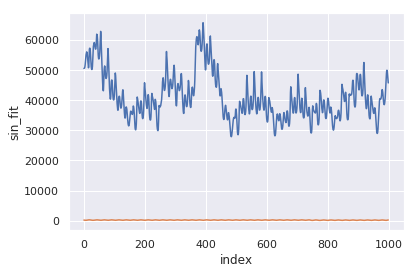

In [21]:
sns.lineplot(x = 'index', y  = 'load', data = elec_merged_df.reset_index().head(n=1000))
sns.lineplot(x = 'index', y  = 'sin_fit', data = elec_merged_df.reset_index().head(n=1000))

In [32]:
[print("gen ms{0} = month == {1}".format(i, i)) for i in range(1,25)];

gen ms1 = month == 1
gen ms2 = month == 2
gen ms3 = month == 3
gen ms4 = month == 4
gen ms5 = month == 5
gen ms6 = month == 6
gen ms7 = month == 7
gen ms8 = month == 8
gen ms9 = month == 9
gen ms10 = month == 10
gen ms11 = month == 11
gen ms12 = month == 12
gen ms13 = month == 13
gen ms14 = month == 14
gen ms15 = month == 15
gen ms16 = month == 16
gen ms17 = month == 17
gen ms18 = month == 18
gen ms19 = month == 19
gen ms20 = month == 20
gen ms21 = month == 21
gen ms22 = month == 22
gen ms23 = month == 23
gen ms24 = month == 24


In [29]:
' + '.join(["{{h{0}_dummy}}*h{1}".format(i, i) for i in range(1,25)])

'{h1_dummy}*h1 + {h2_dummy}*h2 + {h3_dummy}*h3 + {h4_dummy}*h4 + {h5_dummy}*h5 + {h6_dummy}*h6 + {h7_dummy}*h7 + {h8_dummy}*h8 + {h9_dummy}*h9 + {h10_dummy}*h10 + {h11_dummy}*h11 + {h12_dummy}*h12 + {h13_dummy}*h13 + {h14_dummy}*h14 + {h15_dummy}*h15 + {h16_dummy}*h16 + {h17_dummy}*h17 + {h18_dummy}*h18 + {h19_dummy}*h19 + {h20_dummy}*h20 + {h21_dummy}*h21 + {h22_dummy}*h22 + {h23_dummy}*h23 + {h24_dummy}*h24'

In [34]:
' + '.join(["{{m{0}_dummy}}*ms{1}".format(i, i) for i in range(1,13)])

'{m1_dummy}*ms1 + {m2_dummy}*ms2 + {m3_dummy}*ms3 + {m4_dummy}*ms4 + {m5_dummy}*ms5 + {m6_dummy}*ms6 + {m7_dummy}*ms7 + {m8_dummy}*ms8 + {m9_dummy}*ms9 + {m10_dummy}*ms10 + {m11_dummy}*ms11 + {m12_dummy}*ms12'